In [7]:
import igraph
import numpy as np
import pandas as pd
import sys
sys.path.append('../utils')
from utils import get_behav_data
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import KFold
from r_to_py_utils import GPArotation, missForest
from fancyimpute import SoftImpute
%matplotlib inline

### Get best number of components based on CV ML

In [3]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

In [4]:
# find best number of components
data = get_behav_data(file = 'taskdata_clean.csv', full_dataset = True)
imputed_data = get_behav_data(dataset = 'Complete_12-15-2016', file = 'taskdata_imputed.csv')

n_components = range(1,12)
best_score = -np.Inf
best_c = 0
for c in n_components:
    print('N Components: %s' % c)
    fa=FactorAnalysis(c)
    kf = KFold(n_splits = 4)
    scores = []
    for train_index, test_index in kf.split(data.values):
        data_train, data_test = data.iloc[train_index], data.iloc[test_index]
        # replace with missForest later
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        fa.fit(imputed_train)
        scores.append(fa.score(imputed_test))
    score = np.mean(scores)
    if score>best_score:
        best_score = score
        best_c = c
print('Best Component: ', best_c)

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Discovery_12-15-2016
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Validation_12-15-2016
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_12-15-2016
N Components: 1
N Components: 2
N Components: 3
N Components: 4
N Components: 5
N Components: 6
N Components: 7
N Components: 8
N Components: 9
N Components: 10
N Components: 11
Best Component:  7


### Plot relationships between solutions at different dimensionalities

In [11]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*4
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    igraph.plot(G, layout = 'rt', **{'inline': False, 'vertex_label': range(len(G.vs)), 'edge_width':[w for w in G.es['weight']], 'edge_color': G.es['color'], 'bbox': (1000,1000)})
    #G.write_dot('test.dot')
    return G

# construct array of component similarities
similarities = []
components = range(1,14)
reference = None
for c in components:
    fa=FactorAnalysis(c)
    result = pd.DataFrame(fa.fit_transform(imputed_data.corr().values), imputed_data.columns)
    if c>1:
        result = GPArotation(result, method='oblimin')
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result

# plot tree
similarity_tree = construct_relational_tree(similarities)

## Visualization of optimal factor structure

### Print top variables for each factor

In [12]:
# computed FA with best number of components
fa=FactorAnalysis(best_c)
result = pd.DataFrame(fa.fit_transform(imputed_data.corr()), imputed_data.columns)
result = GPArotation(result, method='oblimin')

n = 6 # number of variables to display
for i,column in result.iteritems():
    sort_index = np.argsort(abs(column))[::-1]
    top_vars = imputed_data.columns[sort_index][0:n]
    loadings = list(column[sort_index][0:n])
    print('\nFACTOR %s' % i)
    print(pd.DataFrame({'var':top_vars,'loading':loadings}, columns = ['var','loading']))


FACTOR 0
                                              var   loading
0             kirby.hyp_discount_rate_small.logTr  4.945826
1            kirby.hyp_discount_rate_medium.logTr  4.719310
2             kirby.hyp_discount_rate_large.logTr  4.595528
3                discount_titrate.percent_patient -4.427718
4  bickel_titrator.hyp_discount_rate_medium.logTr  3.404084
5   bickel_titrator.hyp_discount_rate_large.logTr  2.442720

FACTOR 1
                                      var   loading
0                  stop_signal.hddm_drift  2.754234
1                        simon.hddm_drift  2.495527
2   stim_selective_stop_signal.hddm_drift  2.422112
3         choice_reaction_time.hddm_drift  2.365071
4  motor_selective_stop_signal.hddm_drift  2.362766
5         stim_selective_stop_signal.SSRT -2.168388

FACTOR 2
                                                 var   loading
0  angling_risk_task_always_sunny.keep_adjusted_c...  5.260513
1   angling_risk_task_always_sunny.keep_loss_percent  4.8899

### Sum over task variables (extrememly questionable) and then plot the relationships across tasks

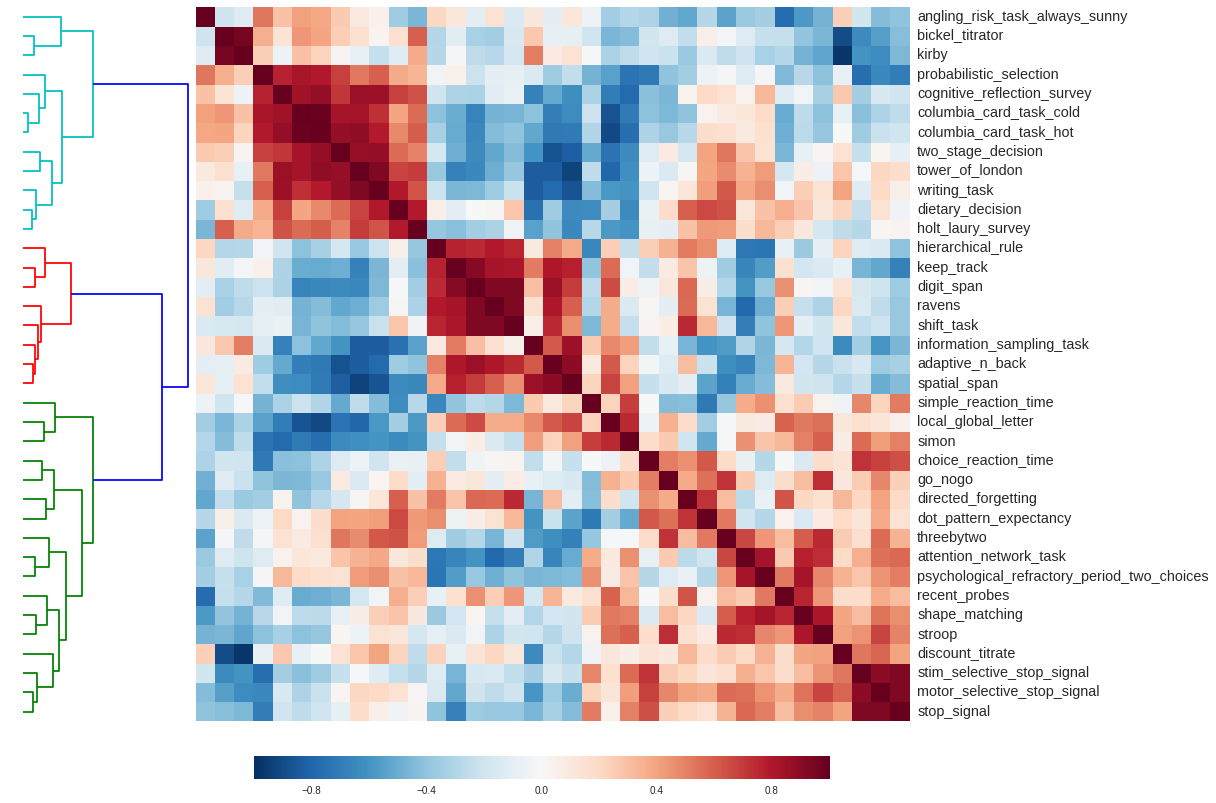

In [16]:
from plot_utils import dendroheatmap_left
# *****************************************************************************
# sum over tasks
# *****************************************************************************
tasks = np.unique([i.split('.')[0] for i in data.columns])
task_sums = {}
for task in tasks:  
    task_sums[task] = result.filter(regex=task,axis=0).sum()
task_sums = pd.DataFrame(task_sums).T
dendroheatmap = dendroheatmap_left(task_sums.T.corr())

### multidimensional scaling

In [ ]:
# *****************************************************************************
# visualize the similarity of the measurements in FA space
# *****************************************************************************

from data_preparation_utils import convert_var_names
from graph_utils import distcorr_mat
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import seaborn as sns

seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

tsne = manifold.TSNE(n_components=2, random_state=seed, metric="precomputed")

# compute distances between variables
# using distance correlation
# result_distances = 1-distcorr_mat(result.T.values)
# euclidean
result_distances = euclidean_distances(result)
# transform
mds_transform = mds.fit_transform(result_distances)
tsne_transform = tsne.fit_transform(result_distances)

# plot
tasks = [i.split('.')[0] for i in result.index]
colors = sns.color_palette("husl", len(np.unique(tasks)))

fig, ax = sns.plt.subplots(figsize = (20,20))
ax.scatter(mds_transform[:,0], mds_transform[:,1])

variables = convert_var_names(list(result.index))
for i, txt in enumerate(variables):
    ax.annotate(txt, (mds_transform[i,0],mds_transform[i,1]), size = 15)
